In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-passenger-satisfaction/data_dictionary.csv
/kaggle/input/airline-passenger-satisfaction/airline_passenger_satisfaction.csv


In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sklearn as sk
from math import pi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score,f1_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from itertools import product
from xgboost import plot_importance
from xgboost import XGBClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


In [3]:
#funciones a usar en el proyecto
def univariado_info(df):
  '''Cálculo de información estadistias y genericas de cada columna de un dataframe'''

  #create a dataframe with especificas columnas

  df_info = pd.DataFrame(columns= ["Cantidad", "Tipo", "Faltantes", "Unicos", "Numericos"])
  #loop de todas las variables del dataframe
  for col in df:
      #obtengo info de la columna
      data_series = df[col]
      #lleno dataframe con las columnas iniciales
      df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(), is_numeric_dtype(data_series)]
  
  #calculo el describe 
  df_describe = df.describe(include='all').T[['top', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
  #calculo sesgo y curtosis

  df_stats = pd.DataFrame([df.skew(), df.kurtosis()], index=['sesgo', 'kurt']).T

  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('-')


def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12,ha='center')
        
def get_class_metrics(y_test, y_pred):
  
    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    precision = round(precision_score(y_pred,y_test),3)
    recall = round(recall_score(y_pred,y_test),3)
    
    scores = [acc, f1, precision, recall]
    # Get confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    
      # create confusion matrix
    sns.heatmap(mat, annot=True, fmt='d')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.title('Confusion Matrix', fontsize=14)
    
    return scores, plt, mat

def display_df(scores, model):
    df = pd.DataFrame(scores).T
    df = df.rename(index={0: model}, columns={0: 'Accuracy', 1: 'F1 Score',2 :"Precision", 3:"recall"})
    return(df)


def fit_predict(X_train, X_test, y_train, model, parameters_grid):
    
    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=parameters_grid, cv=10, n_jobs=-1)
    
    # fit estimator
    grid_search.fit(X_train, y_train)
    
    # get best estimator
    best = grid_search.best_estimator_
    
    # predict
    
    y_pred = best.predict(X_test)
    
    return y_pred, grid_search

In [4]:
df=pd.read_csv('../input/airline-passenger-satisfaction/airline_passenger_satisfaction.csv')

In [5]:
df.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,...,3,4,4,5,4,3,3,3,3,Satisfied


In [6]:
df.shape

(129880, 24)

In [7]:
df=df.rename(columns= {'Departure and Arrival Time Convenience':'Dep_arr_tc'})

**FEATURE ENGENIERI - preliminar**

In [8]:
#Agrego  columnas importantes
df["promedio"] = df [["Dep_arr_tc",'Ease of Online Booking',
       'Check-in Service', 'Online Boarding', 'Gate Location',
       'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness',
       'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
       'In-flight Entertainment', 'Baggage Handling']].mean(axis=1)

In [9]:
bins=[0,21,43,64,100]
labels = ['Jovenes','Adulto','Adultos Mayores','Tercera Edad']
df['Age_Category'] = pd.cut(df['Age'],bins,labels = labels)

In [10]:
univariado_info(df)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Cantidad,Tipo,Faltantes,Unicos,Numericos,top,mean,std,min,25%,50%,75%,max,sesgo,kurt
ID,129880,int64,0,129880,True,-,64940.5,37493.270818,1.0,32470.75,64940.5,97410.25,129880.0,0.0,-1.2
Gender,129880,object,0,2,False,Female,-,-,-,-,-,-,-,-,-
Age,129880,int64,0,75,True,-,39.427957,15.11936,7.0,27.0,40.0,51.0,85.0,-0.003606,-0.71914
Customer Type,129880,object,0,2,False,Returning,-,-,-,-,-,-,-,-,-
Type of Travel,129880,object,0,2,False,Business,-,-,-,-,-,-,-,-,-
Class,129880,object,0,3,False,Business,-,-,-,-,-,-,-,-,-
Flight Distance,129880,int64,0,3821,True,-,1190.316392,997.452477,31.0,414.0,844.0,1744.0,4983.0,1.108142,0.265503
Departure Delay,129880,int64,0,466,True,-,14.713713,38.071126,0.0,0.0,0.0,12.0,1592.0,6.82198,100.644546
Arrival Delay,129487,float64,393,472,True,-,15.091129,38.46565,0.0,0.0,0.0,13.0,1584.0,6.670125,95.117114
Dep_arr_tc,129880,int64,0,6,True,-,3.057599,1.526741,0.0,2.0,3.0,4.0,5.0,-0.332469,-1.040896


In [11]:
#evaluamos nulos
df.isnull().sum()

ID                           0
Gender                       0
Age                          0
Customer Type                0
Type of Travel               0
Class                        0
Flight Distance              0
Departure Delay              0
Arrival Delay              393
Dep_arr_tc                   0
Ease of Online Booking       0
Check-in Service             0
Online Boarding              0
Gate Location                0
On-board Service             0
Seat Comfort                 0
Leg Room Service             0
Cleanliness                  0
Food and Drink               0
In-flight Service            0
In-flight Wifi Service       0
In-flight Entertainment      0
Baggage Handling             0
Satisfaction                 0
promedio                     0
Age_Category                 0
dtype: int64


Para rellenar los valores nulos de las demoras de los viajes, decidimos rellenarla con "0" no hubo demoras. Ya que la variable demora puede ser influyente en la clasificacion de satisfactoria o no de la experiencia del viaje. Y si se llenara con una media o con un valor promedio, segun la distancia del viaje, se estaria dando por supuesto que si existió una demora, cuando en realidad no se sabe si existió o no demora cuando no se cargo el dato. Para validar esta hipótesis vamos a calcular el promedio de satisfacción general y el promedio de satisfaccion cuando hubo demora, para ver si con demora es menor la satisfaccion.

In [12]:

Porce_satisfaccion = df["Satisfaction"].value_counts(normalize = True)
dfmask = df['Arrival Delay']>0
dfdelay = df[dfmask]
Porce_satisfacciondelay = dfdelay["Satisfaction"].value_counts(normalize = True)


Text(0.5, 1.0, 'Satisfaction con Delay')

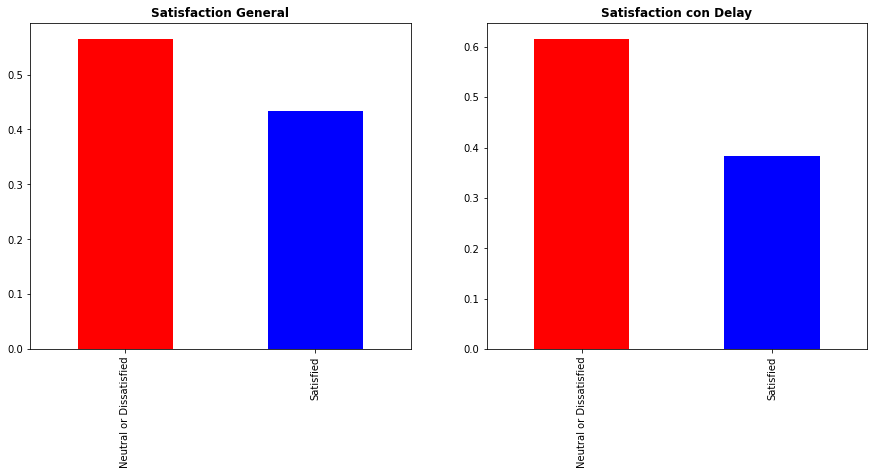

In [13]:
fig , axes = plt.subplots(nrows = 1, ncols=2, figsize=(15,6))
Porce_satisfaccion.plot(kind="bar",color=["r","b"],ax=axes[0])
Porce_satisfacciondelay.plot(kind="bar",color=["r","b"],ax=axes[1])

axes[0].set_title('Satisfaction General', 
             fontweight ="bold")
axes[1].set_title('Satisfaction con Delay', 
             fontweight ="bold")



In [14]:
print("La diferencia de satisfaccion cuando hay demoras es de",round(Porce_satisfacciondelay[0]-Porce_satisfaccion[0],3),)
print("La diferencia de satisfaccion cuando hay demoras es porcentualmente mayor en:",round((Porce_satisfacciondelay[0]-Porce_satisfaccion[0])/Porce_satisfacciondelay[0],3))
print("El porcentaje de nulos contra el total de viajes con demora es de:", round(393/ dfdelay.shape[0],4))
print("El porcentaje de nulos contra el total de filas es de:", round(393/ df.shape[0],5))

La diferencia de satisfaccion cuando hay demoras es de 0.051
La diferencia de satisfaccion cuando hay demoras es porcentualmente mayor en: 0.082
El porcentaje de nulos contra el total de viajes con demora es de: 0.0069
El porcentaje de nulos contra el total de filas es de: 0.00303


**CONCLUSIONES**

Podemos observar que cuando el viaje tiene demora la clasificación de satisfaccion deteriora en un 8% sobre el promedio anterior, o en 5 puntos lineales. Motivo por el cual reafirmamos el reemplazo del campo de nan con valores igual a "0"(ceros)
Por otro lado, la cantidad de nulos (393) es un porcenaje muy bajo tanto en relacion a la cantidad de viajes con demoras como en relacion a la cantidad de filas del data frame. Por lo que concluimos reexpresar con valor = 0

In [15]:
#Relleno los valores nulos en un nuevo dataframe

df["Arrival Delay"].fillna (0, inplace=True)

ANALISIS UNIVARIADO - BIVARIADO - MULTIVARIADO

In [16]:
univariado_info(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Cantidad,Tipo,Faltantes,Unicos,Numericos,top,mean,std,min,25%,50%,75%,max,sesgo,kurt
ID,129880,int64,0,129880,True,-,64940.5,37493.270818,1.0,32470.75,64940.5,97410.25,129880.0,0.0,-1.2
Gender,129880,object,0,2,False,Female,-,-,-,-,-,-,-,-,-
Age,129880,int64,0,75,True,-,39.427957,15.11936,7.0,27.0,40.0,51.0,85.0,-0.003606,-0.71914
Customer Type,129880,object,0,2,False,Returning,-,-,-,-,-,-,-,-,-
Type of Travel,129880,object,0,2,False,Business,-,-,-,-,-,-,-,-,-
Class,129880,object,0,3,False,Business,-,-,-,-,-,-,-,-,-
Flight Distance,129880,int64,0,3821,True,-,1190.316392,997.452477,31.0,414.0,844.0,1744.0,4983.0,1.108142,0.265503
Departure Delay,129880,int64,0,466,True,-,14.713713,38.071126,0.0,0.0,0.0,12.0,1592.0,6.82198,100.644546
Arrival Delay,129880,float64,0,472,True,-,15.045465,38.416353,0.0,0.0,0.0,13.0,1584.0,6.678957,95.355105
Dep_arr_tc,129880,int64,0,6,True,-,3.057599,1.526741,0.0,2.0,3.0,4.0,5.0,-0.332469,-1.040896


ANALISIS DE LA INFORMACIO ESTADISTICA CALCULADA:

Tenemos variables Categoricas propiamente dichas : Gender, Age , Customer Type, Type of Travel, Class. 

Con todas estas varibles categoricas podria luego intentar armar segmentaciones de clientes.

Para la variable edad, podria armar rango de edades separando cada 21 años, diferenciando jovenes de 0 hasta 21, adultos de 22 hasta 42, adultos mayores de 43 a 64 y tercera edad de 65 en adelante.

La variable Flight distance tambien se podria ver de categorizarla entre ['Muy Cortos',"Cortos",'Media Distancia','Largos',"Muy Largos"]

Las variables numericas que son los resultados de las encuestas tambien son categoricas, ya que en realidad no son continuas. podria referirse a categorias como ser (malo, regulamalo, regular, bueno, muy bueno, excelente).

A su vez en los datos se ve un comportamiento normal, no se ven datos anomalos.

In [17]:
Porce_satisfaccion = df["Satisfaction"].value_counts(normalize = True)
Porce_gender = df["Gender"].value_counts(normalize = True)
Porce_class = df["Class"].value_counts(normalize = True)
Porce_Type_T = df["Type of Travel"].value_counts(normalize = True)
Porce_Customer = df["Customer Type"].value_counts(normalize = True)
print(Porce_satisfaccion)
print(Porce_gender)
print(Porce_Type_T)
print(Porce_Customer)

Neutral or Dissatisfied    0.565537
Satisfied                  0.434463
Name: Satisfaction, dtype: float64
Female    0.507384
Male      0.492616
Name: Gender, dtype: float64
Business    0.690584
Personal    0.309416
Name: Type of Travel, dtype: float64
Returning     0.816908
First-time    0.183092
Name: Customer Type, dtype: float64


In [18]:
Promediosevaluaciones = df.groupby(["Satisfaction"]).promedio.mean()
Promediosevaluaciones

Satisfaction
Neutral or Dissatisfied    2.953987
Satisfied                  3.615218
Name: promedio, dtype: float64

Text(0.5, 1.0, 'Promedio de Satisfactores')

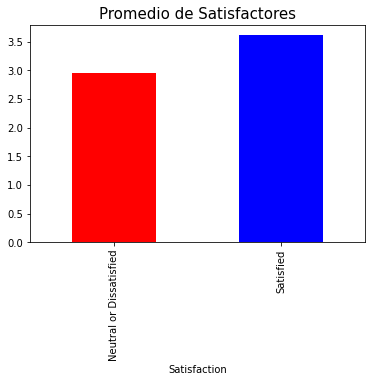

In [19]:
from numpy.core.fromnumeric import size
Promediosevaluaciones = df.groupby(["Satisfaction"]).promedio.mean().plot(kind = "bar",color=["r","b"])
plt.title("Promedio de Satisfactores",size=15)

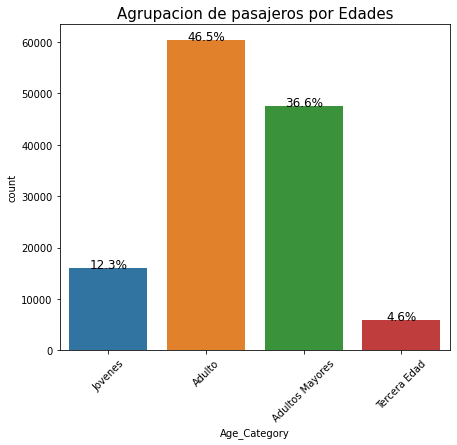

In [20]:
plt.figure(figsize= (7,6))
plt.title("Agrupacion de pasajeros por Edades", fontsize=15)
ax = sns.countplot(data=df, x ="Age_Category")
plt.xticks(rotation=45, size=10);
without_hue(ax, df.Age_Category)

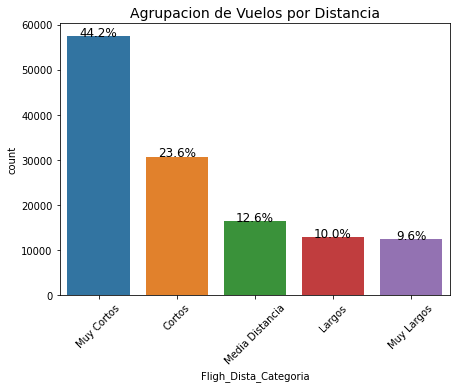

In [21]:
bins=[0,700,1400,2100,2800,5000]
labels = ['Muy Cortos',"Cortos",'Media Distancia','Largos',"Muy Largos"]
df['Fligh_Dista_Categoria'] = pd.cut(df['Flight Distance'],bins,labels = labels)
plt.figure(figsize= (7,5))
ax = sns.countplot(data=df, x ="Fligh_Dista_Categoria")
plt.xticks(rotation=45, size=10);
plt.title("Agrupacion de Vuelos por Distancia", fontsize=14)
without_hue(ax, df.Fligh_Dista_Categoria)


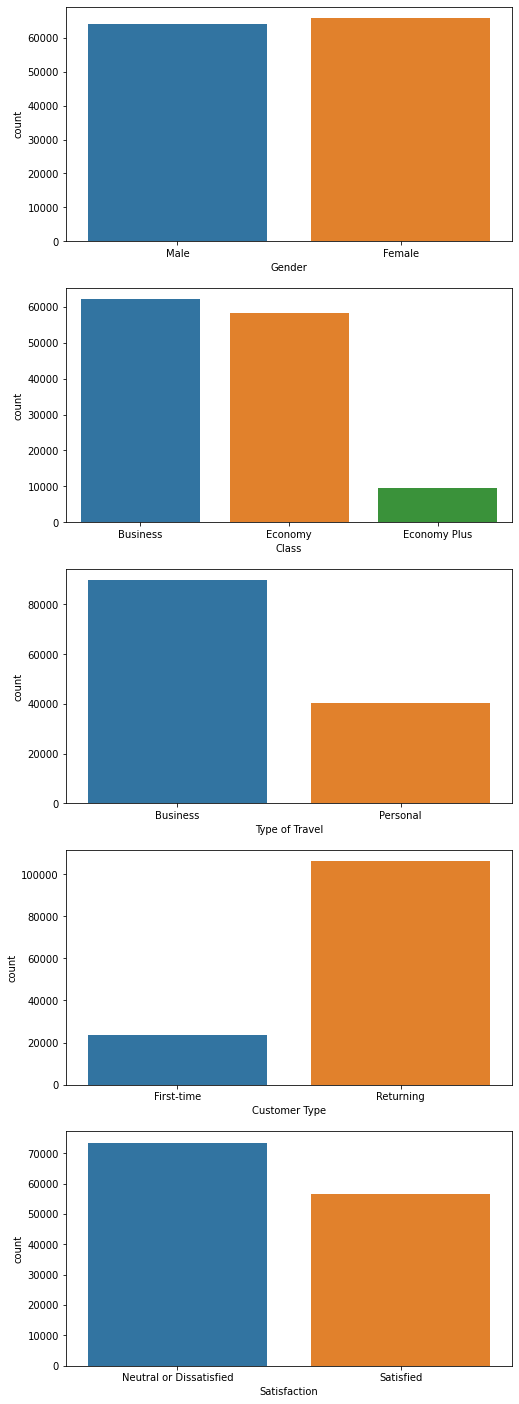

In [22]:
fig , axes = plt.subplots(nrows = 5, ncols=1, figsize=(8,25))
sns.color_palette("muted")
sns.countplot(x=df["Gender"].astype(str), ax=axes[0])
sns.countplot(x=df["Class"].astype(str), ax=axes[1])
sns.countplot(x=df["Type of Travel"].astype(str), ax=axes[2])
sns.countplot(x=df["Customer Type"].astype(str), ax=axes[3])
sns.countplot(x=df["Satisfaction"].astype(str), ax=axes[4]);



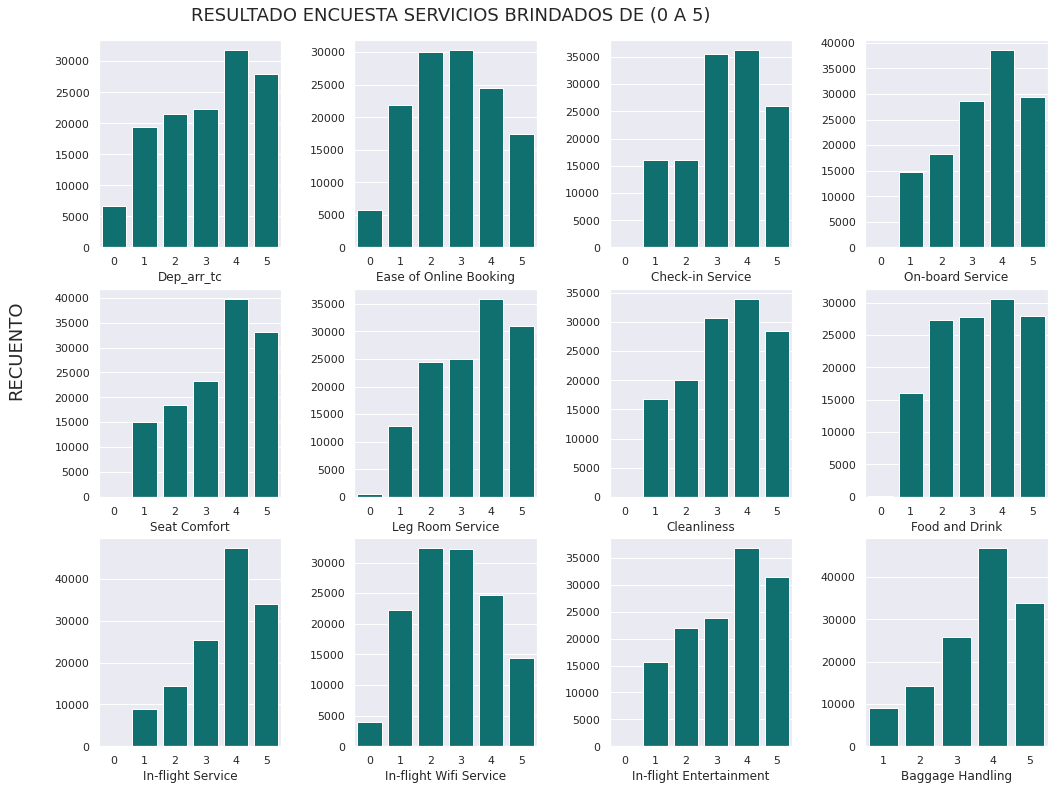

In [23]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 4, figsize=(17, 13))
fig.text(0.05, 0.5, "RECUENTO", rotation ="vertical", fontsize=18)
fig.text(0.2, 0.9, "RESULTADO ENCUESTA SERVICIOS BRINDADOS DE (0 A 5)", fontsize=18)

sns.countplot(data=df, x="Dep_arr_tc", color="teal", ax=axs[0, 0]).set_ylabel("")
sns.countplot(data=df, x="Ease of Online Booking", color="teal", ax=axs[0, 1]).set_ylabel("")
sns.countplot(data=df, x="Check-in Service", color="teal", ax=axs[0, 2]).set_ylabel("")
sns.countplot(data=df, x="On-board Service", color="teal", ax=axs[0, 3]).set_ylabel("")
sns.countplot(data=df, x="Seat Comfort", color="teal", ax=axs[1, 0]).set_ylabel("")
sns.countplot(data=df, x="Leg Room Service", color="teal", ax=axs[1, 1]).set_ylabel("")
sns.countplot(data=df, x="Cleanliness", color="teal", ax=axs[1, 2]).set_ylabel("")
sns.countplot(data=df, x="Food and Drink", color="teal", ax=axs[1, 3]).set_ylabel("")
sns.countplot(data=df, x="In-flight Service", color="teal", ax=axs[2, 0]).set_ylabel("")
sns.countplot(data=df, x="In-flight Wifi Service", color="teal", ax=axs[2, 1]).set_ylabel("")
sns.countplot(data=df, x="In-flight Entertainment", color="teal", ax=axs[2,2]).set_ylabel("")
sns.countplot(data=df, x="Baggage Handling", color="teal", ax=axs[2, 3]).set_ylabel("")

plt.subplots_adjust(wspace =.4)
plt.show()


**Observaciones de los Graficos**

Podemos observar el promedio general de los serv. otorgados por la empresa, 
mientras que servicios tales como "Check-in Serv", "On-board Serv",
"Seat Comfort","Cleanliness","Food and drink" y "In-flight Entertainment", no tuvieron en ningun momento un servicio deficiente (puntuación cero)
Otros serv. como "Departure and Arrival Time Convenience" o "Ease of Online Booking" los usuarios perciben falencias considerables. 
Paralelamente, los servicios de "Ease of Online Booking","In-flight Wifi Service", muentran una distribución simétrica entre los val

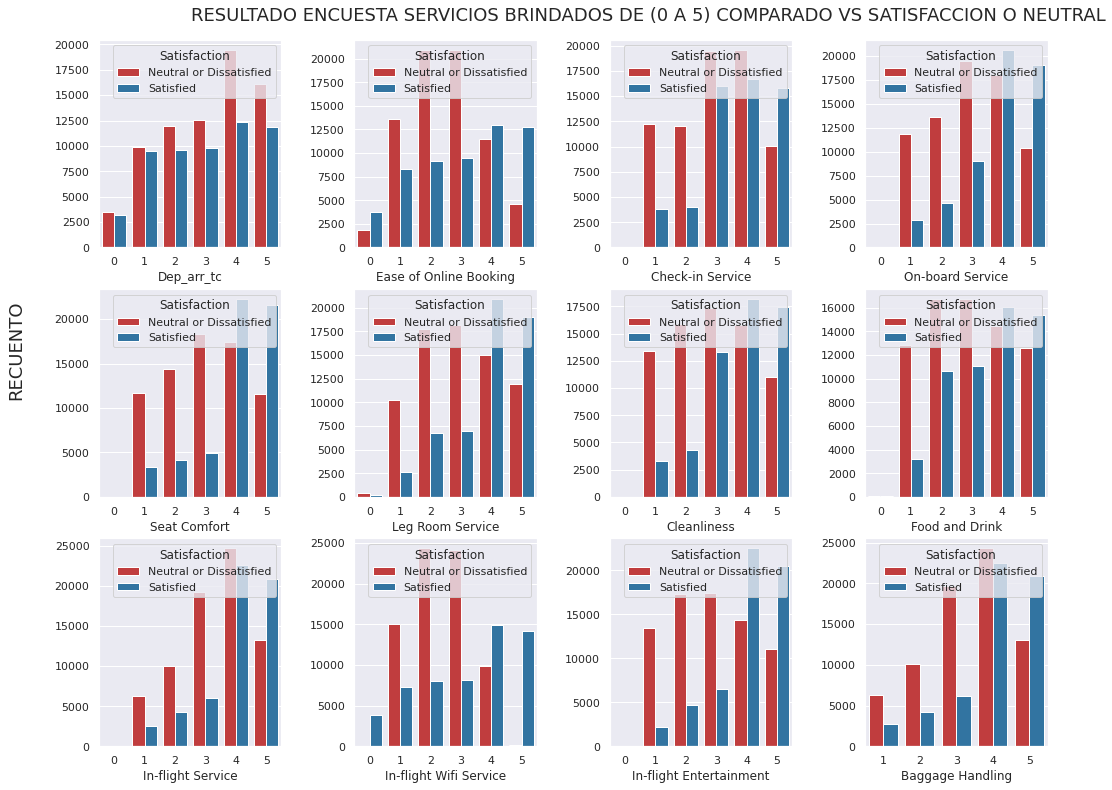

In [24]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 4, figsize=(17, 13))
fig.text(0.05, 0.5, "RECUENTO", rotation ="vertical", fontsize=18)
fig.text(0.2, 0.9, "RESULTADO ENCUESTA SERVICIOS BRINDADOS DE (0 A 5) COMPARADO VS SATISFACCION O NEUTRAL", fontsize=18)

sns.countplot(data=df, x="Dep_arr_tc", palette=['tab:red', 'tab:blue'], ax=axs[0, 0],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Ease of Online Booking", palette=['tab:red', 'tab:blue'], ax=axs[0, 1],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Check-in Service", palette=['tab:red', 'tab:blue'], ax=axs[0, 2],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="On-board Service", palette=['tab:red', 'tab:blue'], ax=axs[0, 3],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Seat Comfort", palette=['tab:red', 'tab:blue'], ax=axs[1, 0],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Leg Room Service", palette=['tab:red', 'tab:blue'], ax=axs[1, 1],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Cleanliness", palette=['tab:red', 'tab:blue'], ax=axs[1, 2],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Food and Drink", palette=['tab:red', 'tab:blue'], ax=axs[1, 3],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="In-flight Service",palette=['tab:red', 'tab:blue'], ax=axs[2, 0],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="In-flight Wifi Service", palette=['tab:red', 'tab:blue'], ax=axs[2, 1],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="In-flight Entertainment", palette=['tab:red', 'tab:blue'], ax=axs[2,2],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Baggage Handling", palette=['tab:red', 'tab:blue'], ax=axs[2, 3],hue="Satisfaction").set_ylabel("")


plt.subplots_adjust(wspace =.4)

plt.show()

**Observaciones de los Graficos**

La información más destacable luego del análisis es que cuando el servicio de Wifi funciona correctamente nunca se valoró la satisfacción como neutral o insatisfechas


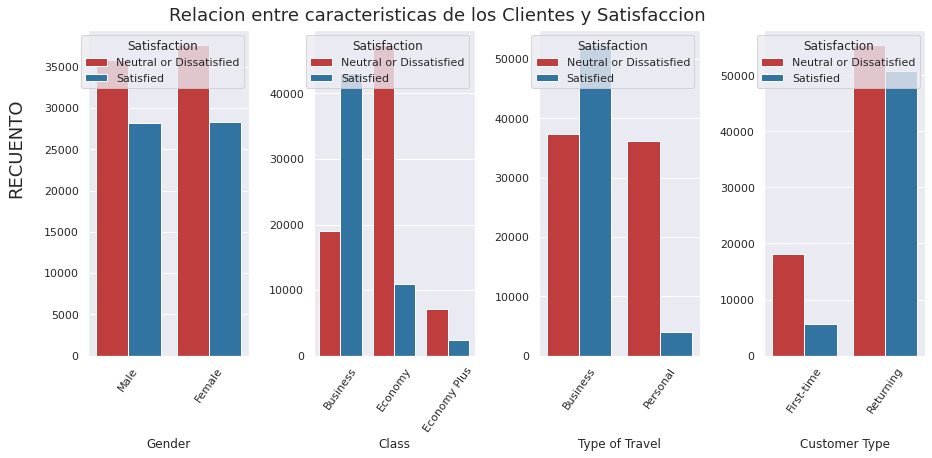

In [25]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
fig.text(0.05, 0.5, "RECUENTO", rotation ="vertical", fontsize=18)
fig.text(0.2, 0.9, "Relacion entre caracteristicas de los Clientes y Satisfaccion", fontsize=18)
fig.align_xlabels()

for tick in axs[0].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()
for tick in axs[1].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()
for tick in axs[2].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()
for tick in axs[3].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()

sns.countplot(data=df, x="Gender", palette=['tab:red', 'tab:blue'], ax=axs[0],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Class", palette=['tab:red', 'tab:blue'], ax=axs[1],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Type of Travel", palette=['tab:red', 'tab:blue'], ax=axs[2],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Customer Type", palette=['tab:red', 'tab:blue'], ax=axs[3],hue="Satisfaction").set_ylabel("")

plt.subplots_adjust(wspace =.4)
plt.show()

**Observaciones de los Graficos**

Del gráfico podemos observar que las personas de "Business" se muestran considerablemente más satisfechas que las personas de "Economy". A su vez, aquellas personas que ya son clientes, es decir, que no es su primer vuelo en dicha aerolinea, se muestran proporcionalmente más satisfechas que quienes vuelan por primera vez

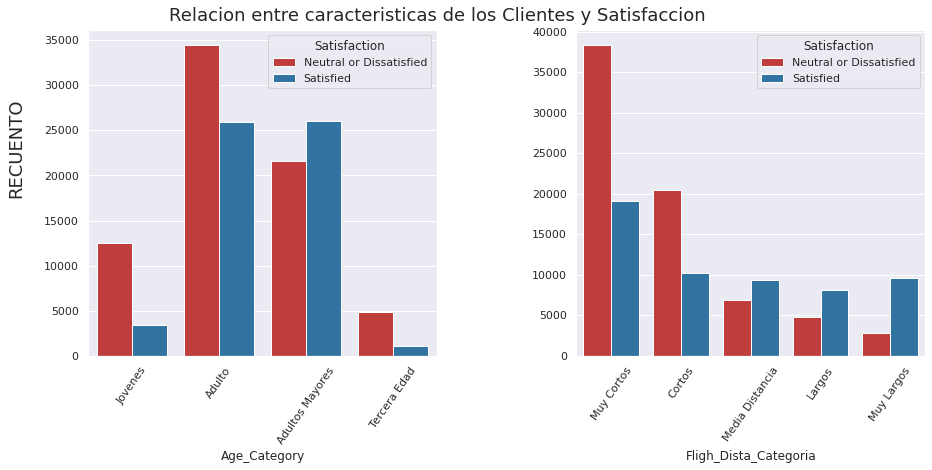

In [26]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.text(0.05, 0.5, "RECUENTO", rotation ="vertical", fontsize=18)
fig.text(0.2, 0.9, "Relacion entre caracteristicas de los Clientes y Satisfaccion", fontsize=18)
fig.align_xlabels()

for tick in axs[0].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()
for tick in axs[1].get_xticklabels():
    tick.set_rotation(55)
fig.align_xlabels()

sns.countplot(data=df, x="Age_Category", palette=['tab:red', 'tab:blue'], ax=axs[0],hue="Satisfaction").set_ylabel("")
sns.countplot(data=df, x="Fligh_Dista_Categoria", palette=['tab:red', 'tab:blue'], ax=axs[1],hue="Satisfaction").set_ylabel("")


plt.subplots_adjust(wspace =.4)
plt.show()



** Observacion de los Graficos**

Se observa claramente que la mayor insatisfacción se encuentra en los viajes cortos. Podemos considerar que las personas se encuentran apuradas, o que las aerolíneas no ofrecen ningún tipo de servicio complementario, así como sus aviones son de menor tamaño y servicios, a su vez, vemos  que los jóvenes se encuentran relativamente mucho más insatisfechos que la media.

<AxesSubplot:xlabel='Age_Category', ylabel='Baggage Handling'>

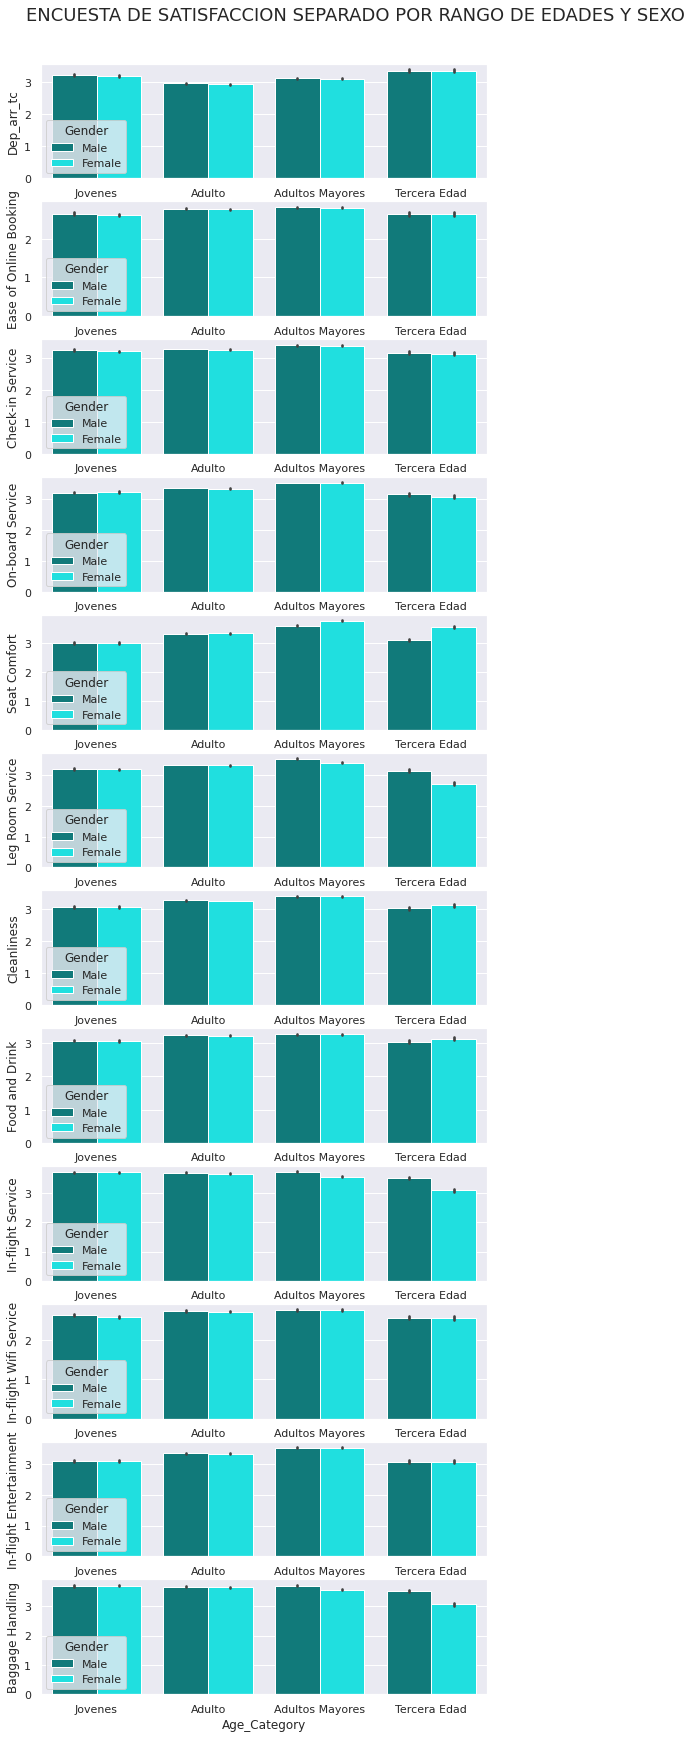

<Figure size 1440x360 with 0 Axes>

In [27]:
#Gráfico de vioin: sexo - rango de edad - puntaje de servicios

fig , axes = plt.subplots(nrows = 12, ncols=1, figsize=(8,30))
fig.text(0.1, 0.9, "ENCUESTA DE SATISFACCION SEPARADO POR RANGO DE EDADES Y SEXO", fontsize=18)

plt.figure(figsize=(20,5))
sns.barplot(x='Age_Category',y="Dep_arr_tc", data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[0])
sns.barplot(x='Age_Category',y="Ease of Online Booking",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[1])
sns.barplot(x='Age_Category',y="Check-in Service",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[2])
sns.barplot(x='Age_Category',y="On-board Service",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[3])
sns.barplot(x='Age_Category',y="Seat Comfort",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[4])
sns.barplot(x='Age_Category',y="Leg Room Service",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[5])
sns.barplot(x='Age_Category',y="Cleanliness",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[6])
sns.barplot(x='Age_Category',y="Food and Drink",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[7])
sns.barplot(x='Age_Category',y="In-flight Service",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[8])
sns.barplot(x='Age_Category',y="In-flight Wifi Service",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[9])
sns.barplot(x='Age_Category',y="In-flight Entertainment",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[10])
sns.barplot(x='Age_Category',y="Baggage Handling",data=df,palette=['#008B8B','#00FFFF'], hue= 'Gender', ax= axes[11])

<AxesSubplot:xlabel='Gender', ylabel='Baggage Handling'>

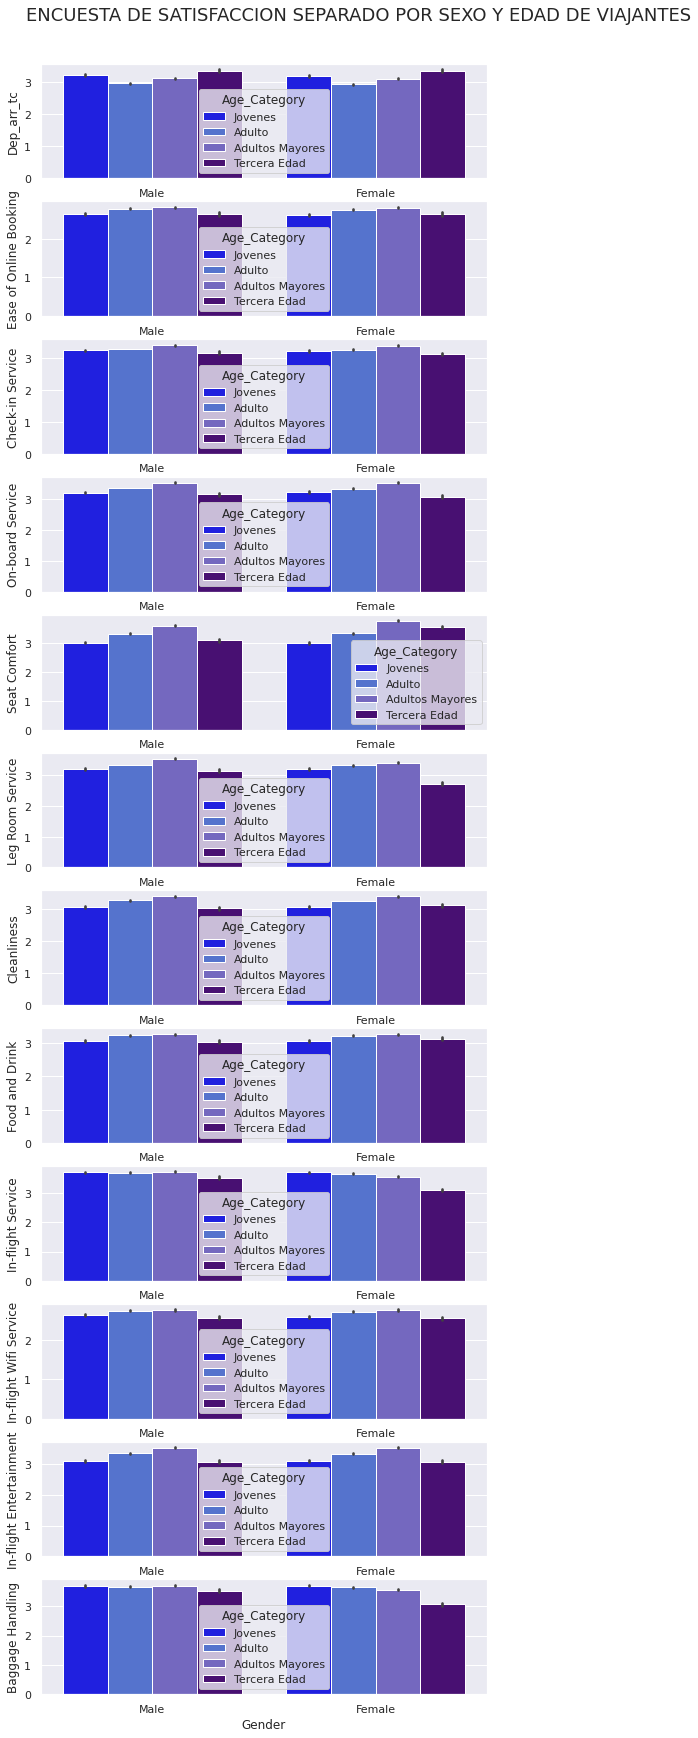

<Figure size 1440x360 with 0 Axes>

In [28]:
fig , axes = plt.subplots(nrows = 12, ncols=1, figsize=(8,30))
fig.text(0.1, 0.9, "ENCUESTA DE SATISFACCION SEPARADO POR SEXO Y EDAD DE VIAJANTES", fontsize=18)

plt.figure(figsize=(20,5))
sns.barplot(x='Gender',y="Dep_arr_tc", data=df,palette=["blue","royalblue","slateblue","indigo"], hue= "Age_Category", ax= axes[0])
sns.barplot(x='Gender',y="Ease of Online Booking",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category', ax= axes[1])
sns.barplot(x='Gender',y="Check-in Service",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category', ax= axes[2])
sns.barplot(x='Gender',y="On-board Service",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[3])
sns.barplot(x='Gender',y="Seat Comfort",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[4])
sns.barplot(x='Gender',y="Leg Room Service",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[5])
sns.barplot(x='Gender',y="Cleanliness",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[6])
sns.barplot(x='Gender',y="Food and Drink",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[7])
sns.barplot(x='Gender',y="In-flight Service",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[8])
sns.barplot(x='Gender',y="In-flight Wifi Service",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[9])
sns.barplot(x='Gender',y="In-flight Entertainment",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category',  ax= axes[10])
sns.barplot(x='Gender',y="Baggage Handling",data=df,palette=["blue","royalblue","slateblue","indigo"], hue= 'Age_Category', ax= axes[11])

**Observaciones de los Gráficos**

Podemos observar que la gente de la tercera edad, sobre todo las mujeres, quedaron insatisfechas con el servicio de llevado de valijas, así como los jovenes con los servicios de entretenimiento.

De alguna manera podemos, tambien, observar que la valoración de los servicios depende de la necesidad sobre los mismos. Ya que las mujeres de la tercera edad necesitan que se las ayude con sus valijas y la falta de este servicio es muy insatisfactoria.

Satisfaccion  = (servicio vs expectativa). Cuando una rango etario clasifica un servicio peor que otro rango etario dentro del mismo vuelo, la conclusion es que ese rango etario tiene una mayor expectativa sobre dicho servicio por eso su percepcion de satisfaccion es mas exigente por lo que termina evaluando de manera mas negativa el mismo servicio. Lo que nos ofrece informacion sobre que servicio prestar a que personas.

In [29]:
df_encuestas= df.drop(['ID','Gender','Customer Type','Class','Age', 'Satisfaction', 'Fligh_Dista_Categoria','Type of Travel', 'Flight Distance', 'Departure Delay', 'Arrival Delay', 'Arrival Delay', 'promedio'], axis=1)
df_agescategorias = df_encuestas.groupby("Age_Category").mean()
df_agescategorias

,Dep_arr_tc,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
Age_Category,,,,,,,,,,,,,,
Jovenes,3.201253,2.628947,3.222870,2.679261,2.975125,3.218484,3.028571,3.197431,3.081015,3.062782,3.697055,2.624373,3.085777,3.691604
Adulto,2.945012,2.764758,3.271724,3.133369,2.978545,3.343279,3.348034,3.331699,3.269935,3.215643,3.668633,2.738498,3.332577,3.654385
Adultos Mayores,3.114360,2.804637,3.398504,3.609399,2.979823,3.522132,3.709677,3.478036,3.402287,3.254277,3.633129,2.771176,3.518118,3.626760
Tercera Edad,3.358850,2.638810,3.143741,3.148253,2.942337,3.116664,3.350326,2.942504,3.077219,3.080227,3.301187,2.570282,3.069029,3.291325


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.


<function matplotlib.pyplot.show(close=None, block=None)>

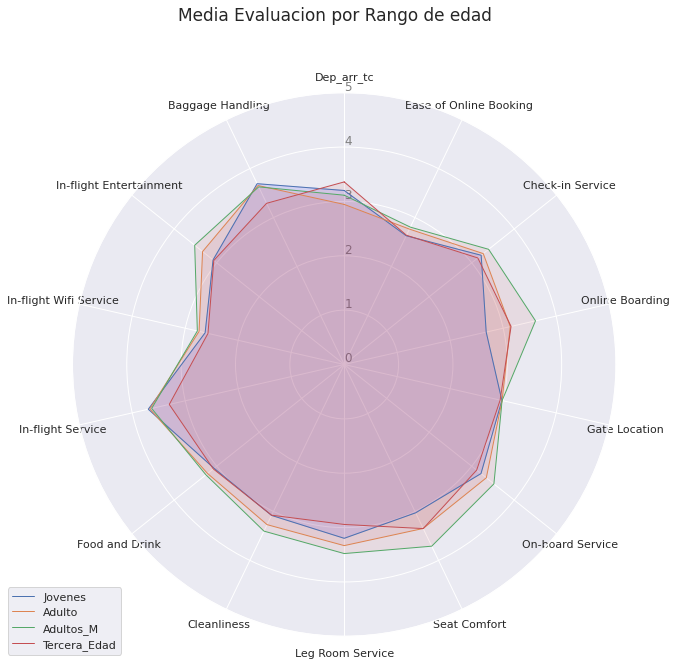

In [30]:
#Parámetros
params= list(df_encuestas.columns)
params=params [0:14]
plt.figure(figsize=(10,10))


#Valores
Jovenes = list(df_agescategorias.loc["Jovenes"])
Adultos = list(df_agescategorias.loc["Adulto"])
Adultos_M = list(df_agescategorias.loc["Adultos Mayores"])
Tercera_Edad = list(df_agescategorias.loc["Tercera Edad"])


#Gráfico
N = len(params)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


plt.xticks(angles[:-1],params)

ax.set_rlabel_position(0)
plt.yticks([0,1,2,3,4,5], ["0","1","2","3","4","5"], color="grey", size=12)
plt.ylim(0,5)

valuesj = Jovenes
valuesj += valuesj[:1]
ax.plot(angles,valuesj, linewidth=1, linestyle='solid', label ="Jovenes")
ax.fill(angles, valuesj,"r", alpha=0.1, color="blue")

valuesa = Adultos
valuesa += valuesa[:1]
ax.plot(angles,valuesa, linewidth=1, linestyle='solid', label ="Adulto")
ax.fill(angles,valuesa,"r", alpha=0.1)


valuesam = Adultos_M
valuesam += valuesam[:1]
ax.plot(angles,valuesam, linewidth=1, linestyle='solid', label ="Adultos_M")
ax.fill(angles,valuesam,"r", alpha=0.1)

valueste = Tercera_Edad
valueste += valueste[:1]
ax.plot(angles,valueste, linewidth=1, linestyle='solid', label ="Tercera_Edad")
ax.fill(angles,valueste,"r", alpha=0.1)


plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.suptitle("Media Evaluacion por Rango de edad", fontsize=17, y = 1);
plt.show

**Observaciones del Grafico**

Podemos observar que los servicios con menor puntuacion son el check - in Service y el servicio de WIfi. A su vez los jovenes suelen ser mas rigurosos en sus evaluaciones y los adultos mayores son el grupo que mejores puntajes le dio a los servicios. 

Diferencias entre los rango etarios:
- Online boarding: los jóvenes ser encuentran por debajo de la media mientras que los adultos mayores valoraron mucho este servicio.
- El grupo de tercera edad valoró menos los servicios de In Flight Entertainment que el resto de los grupos
- Los jóvenes y tercera edad valoró menos el servicio On board que los Adultos Mayores. 
- Los adultos mayores valoraron significativamente más el servicio Seat Confort que el resto de los grupos, en especial los jóvenes. Sin embargo, el grupo tercera edad le dio peor puntaje al Leg Room Service y los adultos fueron quienes mejor puntaje le dieron.


Podemos observar comportamientos similiares entre los distintos rangos etarios en la satisfaccion/insatisfaccion de la mayoria de los servicios ofrecidos especilamente en: Gate Location, Ease of online booking, 

In [31]:
df.dtypes

ID                            int64
Gender                       object
Age                           int64
Customer Type                object
Type of Travel               object
Class                        object
Flight Distance               int64
Departure Delay               int64
Arrival Delay               float64
Dep_arr_tc                    int64
Ease of Online Booking        int64
Check-in Service              int64
Online Boarding               int64
Gate Location                 int64
On-board Service              int64
Seat Comfort                  int64
Leg Room Service              int64
Cleanliness                   int64
Food and Drink                int64
In-flight Service             int64
In-flight Wifi Service        int64
In-flight Entertainment       int64
Baggage Handling              int64
Satisfaction                 object
promedio                    float64
Age_Category               category
Fligh_Dista_Categoria      category
dtype: object

In [32]:
servicios =  ["Dep_arr_tc",'Ease of Online Booking',
       'Check-in Service', 'Online Boarding', 'Gate Location',
       'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness',
       'Food and Drink', 'In-flight Service', 'In-flight Wifi Service',
       'In-flight Entertainment', 'Baggage Handling']

delay =  ['Departure Delay', 'Arrival Delay']

cat_col = ["Gender", 'Customer Type','Type of Travel', 'Class']

other_col = ['Age','Flight Distance',"promedio"]

target__A =  ['Satisfaction']

Agregadas = ["Age_Category","Fligh_Dista_Categoria"]

In [33]:
#creo columna nueva con la variable satisfaccion en numeros
df["SatisfaccionTarget"] = [int (1) if i == 'Satisfied'else int(0) for i in df["Satisfaction"] ]

In [34]:
#SPLIT
X = df[servicios]
y = df['SatisfaccionTarget']
#spliteo de train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#transformo las columnas.
numeric_encoder = MinMaxScaler()
x_minmaxtrain = numeric_encoder.fit_transform(X_train)
x_minmaxtest = numeric_encoder.fit_transform(X_test)

#defino los modelos
RFclassifier = RandomForestClassifier()
parameters_gridrf = {
    'max_depth': [5, 15],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100],
    'max_features': [5, 10]
}



In [35]:
y_predrf, grid_searchrf = fit_predict(x_minmaxtrain, x_minmaxtest,  y_train, RFclassifier, parameters_gridrf)

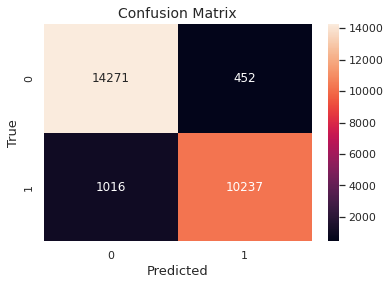

In [36]:
scores, plt, mat = get_class_metrics(y_test, y_predrf)


In [37]:
resrf = display_df(scores,RFclassifier)
resrf

,Accuracy,F1 Score,Precision,recall
RandomForestClassifier(),0.943,0.933,0.91,0.958


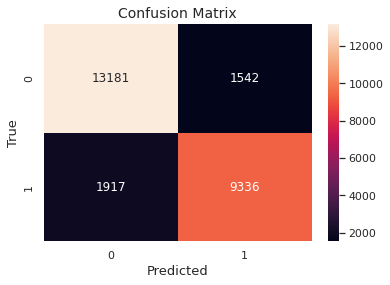

In [38]:
Adaclassifier= AdaBoostClassifier()

parameters_gridada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}

# get predictions
y_pred, grid_search = fit_predict(x_minmaxtrain, x_minmaxtest,  y_train, Adaclassifier, parameters_gridada)

# calculate metrics
scores, plt, mat = get_class_metrics(y_test, y_pred)


In [39]:
resada = display_df(scores,Adaclassifier)
resada

,Accuracy,F1 Score,Precision,recall
AdaBoostClassifier(),0.867,0.844,0.83,0.858


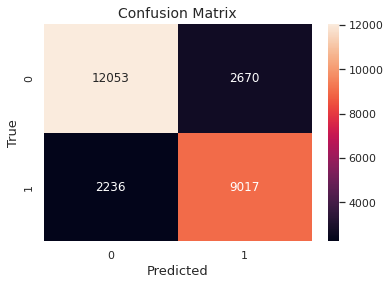

In [40]:
log = LogisticRegression(fit_intercept=True, max_iter=1000)

parameters_grid_log = {'C': [0.001, 0.01, 0.1, 1, 10]}

# get predictions
y_pred, grid_search = fit_predict(x_minmaxtrain, x_minmaxtest,  y_train, log, parameters_grid_log)

# calculate metrics
scores, plt, mat = get_class_metrics(y_test, y_pred)

In [41]:
reslog = display_df(scores,log)
reslog

,Accuracy,F1 Score,Precision,recall
LogisticRegression(max_iter=1000),0.811,0.786,0.801,0.772


In [42]:
comparacion = pd.concat([resrf,resada,reslog]).sort_values(by=["Accuracy"],ascending=False)
comparacion

,Accuracy,F1 Score,Precision,recall
RandomForestClassifier(),0.943,0.933,0.910,0.958
AdaBoostClassifier(),0.867,0.844,0.830,0.858
LogisticRegression(max_iter=1000),0.811,0.786,0.801,0.772


In [43]:
RFclassifierselec=grid_searchrf.best_estimator_
RFclassifierselec

RandomForestClassifier(max_depth=15, max_features=5, min_samples_leaf=2)

In [44]:
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": RFclassifierselec.feature_importances_}
).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df

,feature,importance
3,Online Boarding,0.300993
11,In-flight Wifi Service,0.204572
12,In-flight Entertainment,0.093726
7,Leg Room Service,0.071418
0,Dep_arr_tc,0.052672
1,Ease of Online Booking,0.050401
6,Seat Comfort,0.043747
5,On-board Service,0.037535
4,Gate Location,0.029763
9,Food and Drink,0.027222


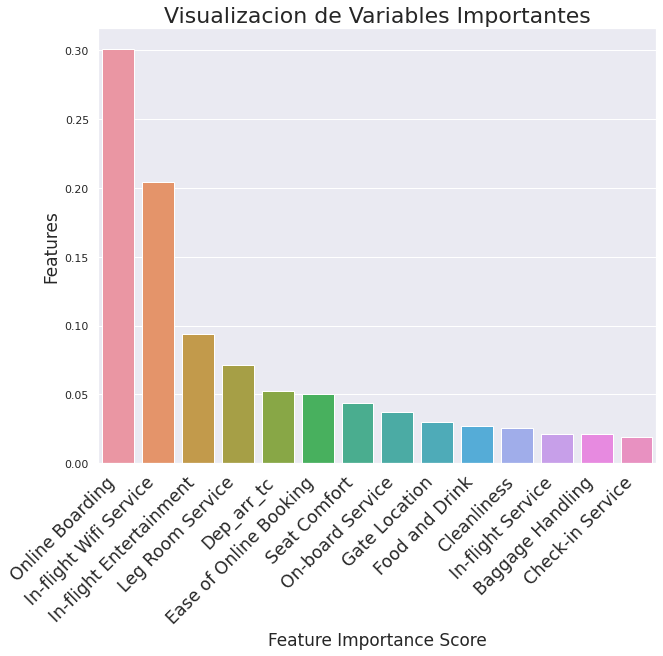

In [45]:
# visualizarcaracterísticas importantes

# Crear un diagrama de barras
plt.figure(figsize=(10,8))
sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
# agregar estiquestas
plt.xlabel("Feature Importance Score",fontsize=17)
plt.ylabel("Features",fontsize=17)
plt.title("Visualizacion de Variables Importantes",fontsize=22)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large");

In [46]:
df_todos= df.copy()

df_todos.drop(['ID',"Satisfaction"], axis=1, inplace=True)
X = df_todos.drop(['SatisfaccionTarget'], axis=1)
y = df_todos['SatisfaccionTarget']
#SPLIT
Xtodos_train, Xtodos_test, ytodos_train, ytodos_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [47]:
df_todos.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Dep_arr_tc,Ease of Online Booking,...,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,promedio,Age_Category,Fligh_Dista_Categoria,SatisfaccionTarget
0,Male,48,First-time,Business,Business,821,2,5.0,3,3,...,5,5,5,3,5,5,3.857143,Adultos Mayores,Cortos,0
1,Female,35,Returning,Business,Business,821,26,39.0,2,2,...,5,3,5,2,5,5,3.785714,Adulto,Cortos,1
2,Male,41,Returning,Business,Business,853,0,0.0,4,4,...,5,5,3,4,3,3,3.928571,Adulto,Cortos,1
3,Male,50,Returning,Business,Business,1905,0,0.0,2,2,...,4,4,5,2,5,5,3.785714,Adultos Mayores,Media Distancia,1
4,Female,49,Returning,Business,Business,3470,0,1.0,3,3,...,5,4,3,3,3,3,3.500000,Adultos Mayores,Muy Largos,1


In [48]:

ohe = OneHotEncoder()
ct = make_column_transformer(
    (ohe,cat_col),
    (ohe,Agregadas),
    (numeric_encoder,servicios,other_col),
    remainder="passthrough")

In [49]:
Xtodos_train = ct.fit_transform(Xtodos_train)
Xtodos_test= ct.fit_transform(Xtodos_test)

In [50]:
y_predrft, grid_searchrft = fit_predict(Xtodos_train, Xtodos_test,  ytodos_train, RFclassifier, parameters_gridrf)
y_predadat, grid_searchadat = fit_predict(Xtodos_train, Xtodos_test,  ytodos_train, Adaclassifier, parameters_gridada)


In [51]:
y_predlogt, grid_searchlogt = fit_predict(Xtodos_train, Xtodos_test,  ytodos_train, log, parameters_grid_log)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


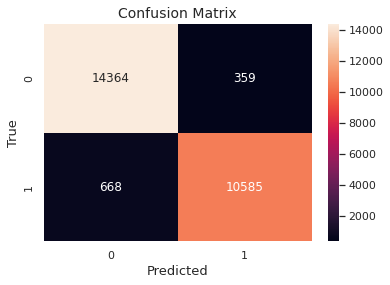

In [52]:
scoresrft, plt, mat = get_class_metrics(y_test, y_predrft)





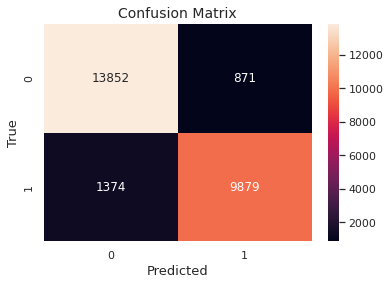

In [53]:
scoresadat, plt, mat = get_class_metrics(y_test, y_predadat)

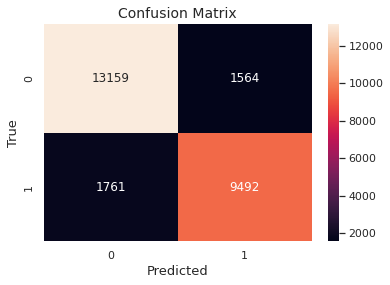

In [54]:
scoreslogt, plt, mat = get_class_metrics(y_test, y_predlogt)

In [55]:
resrft = display_df(scoresrft,RFclassifier)
resadat = display_df(scoresadat,Adaclassifier)
reslogt = display_df(scoreslogt,log)

In [56]:
comparaciontodos = pd.concat([resrft,resadat,reslogt]).sort_values(by=["Accuracy"],ascending=False)
comparaciontodos

,Accuracy,F1 Score,Precision,recall
RandomForestClassifier(),0.960,0.954,0.941,0.967
AdaBoostClassifier(),0.914,0.898,0.878,0.919
LogisticRegression(max_iter=1000),0.872,0.851,0.844,0.859
